# Gemini 2.5 Flash PLOTS
Google, “Gemini 2.5 Flash,” Large language model, 2025. [Online]. Available: https://gemini.google.com

LLM Disclaimer: Debugging was done with the help of ChatGPT: https://chatgpt.com/ 

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# LOAD DAT

In [2]:
#mini_brazilian_dataset = pd.read_csv("mini_dataset.csv")

In [3]:
#with open('folds_mini.pkl','rb') as f:
    #folds_mini = pickle.load(f)

# FUNCTIONS

In [23]:
def evaluate_gemini_flash(gemini_flash_full, target_col='diabetic_retinopathy', 
                          fold_numbers=list(range(10)), is_multiclass=False):
    """
    go across folds
    compute accuracy, F1, precision, recall, balanced accuracy 
    plot the results per fold
    return the per-fold metrics and mean performance
    """
    gemini_flash_full = gemini_flash_full.copy()

    fold_cols = [f'gemini_answer_fold_{i}' for i in fold_numbers]

    if not is_multiclass:
        for col in fold_cols:
            gemini_flash_full[col] = gemini_flash_full[col].map({
                "Diabetic Retinopathy (DR)": 1,
                "Normal": 0
            })

    gemini_flash_full[fold_cols] = gemini_flash_full[fold_cols].apply(pd.to_numeric, errors='coerce')

    metrics = []

    for i in fold_numbers:
        col = f'gemini_answer_fold_{i}'
        valid_rows = gemini_flash_full[[target_col, col]].dropna()
        
        if len(valid_rows) == 0:
            print(f"Fold {i}: NO VALID INFO!!!")
            metrics.append({
                'fold': i,
                'accuracy': np.nan,
                'f1': np.nan,
                'precision': np.nan,
                'recall': np.nan,
                'acc_bal': np.nan
            })
            continue

        y_true = valid_rows[target_col].astype(int)
        y_pred = valid_rows[col].astype(int)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro' if is_multiclass else 'binary', zero_division=0)
        precision = precision_score(y_true, y_pred, average='macro' if is_multiclass else 'binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro' if is_multiclass else 'binary', zero_division=0)
        acc_bal = balanced_accuracy_score(y_true, y_pred)

        metrics.append({
            'fold': i,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'acc_bal': acc_bal
        })

        print(f"Fold {i}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

    metrics_df = pd.DataFrame(metrics)

    acc_all = metrics_df['accuracy'].mean()
    f1_all = metrics_df['f1'].mean()
    print(f"\nMean across folds: Accuracy = {acc_all:.4f}, F1 = {f1_all:.4f}")

    
    mets = ['accuracy','f1','precision','recall','acc_bal']
    n_mets = len(mets)
    n_cols = 3
    n_rows = int(np.ceil(n_mets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols,5*n_rows), sharey=True)
    axes = axes.flatten()

    for ax, m in zip(axes, mets):
        sns.barplot(x='fold', y=m, data=metrics_df, ax=ax, color='skyblue', errorbar=None)
        mean_val = metrics_df[m].mean()
        std_val = metrics_df[m].std()
        ax.axhline(mean_val, color='red', linestyle='--', label=f"Mean = {mean_val:.2f}")
        ax.fill_between(
            x=range(len(metrics_df)),
            y1=mean_val-std_val,
            y2=mean_val+std_val,
            color='red',
            alpha=0.2,
            label="±1 SD"
        )
        for i, val in enumerate(metrics_df[m]):
            if not np.isnan(val):
                ax.text(i, val/2, f"{val:.2f}", ha='center', va='center', fontsize=10)
        ax.set_xticks(range(len(metrics_df['fold'])))
        ax.set_xticklabels(metrics_df['fold'], rotation=45, ha='right')
        ax.set_title(m, fontsize=14)
        ax.set_xlabel("Fold", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0,1)
        ax.legend(loc='lower right', fontsize=10)

    for j in range(len(mets), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    return metrics_df, acc_all, f1_all

In [24]:
def plot_gemini_experiments(metrics_list, labels, fold_numbers=None):
    """
    plot metrics for each experiment on one subplot for each metric
    """
    mets = ['accuracy','f1','precision','recall','acc_bal']
    n_mets = len(mets)
    n_cols = 3
    n_rows = int(np.ceil(n_mets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols,5*n_rows), sharey=True)
    axes = axes.flatten()
    
    if fold_numbers is None:
        fold_numbers = metrics_list[0]['fold'].tolist()
    
    colors = sns.color_palette("tab10", n_colors=len(metrics_list))

    for ax, m in zip(axes, mets):
        for df, label, color in zip(metrics_list, labels, colors):
            vals = df[m].values
            mean_val = np.nanmean(vals)
            std_val = np.nanstd(vals)

            ax.plot(fold_numbers, vals, marker='o', color=color, label=label)
            ax.fill_between(fold_numbers, vals-std_val, vals+std_val, color=color, alpha=0.2)
            ax.axhline(mean_val, color=color, linestyle='--', alpha=0.7)

        ax.set_xticks(fold_numbers)
        ax.set_xticklabels(fold_numbers, rotation=45)
        ax.set_ylim(0,1)
        ax.set_title(m, fontsize=14)
        ax.set_xlabel("Fold", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(True)

    for j in range(len(mets), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
fold_numbers = [0,1,2,3,4,5,6,7,8,9]  

# PLOTS

### Gemini Flash Tau=0.7 BD full

In [26]:
gemini_flash_01_full = pd.read_csv("BD_full_Gemini_flash_tau0.7_01_final.csv")

### Gemini Flash Tau=0.7 BD mini

In [27]:
gemini_flash_01_mini = gemini_flash_01_full[gemini_flash_01_full['image_id'].isin(mini_brazilian_dataset['image_id'])]

### Gemini Flash Tau=0.7 BD mini kinda CoT

In [28]:
gemini_flash_01_cot = pd.read_csv("BD_mini_Gemini_flash_tau0.7_01_cot_final.csv")

### Gemini Flash Tau=0.7 BD mini zero-shot+system instruction+CoT

In [29]:
gemini_flash_01_cot_sys_instr = pd.read_csv("BD_mini_Gemini_flash_tau0.7_01_cot_sys_instr!_final.csv")

### Gemini Flash Tau=0.7 BD mini 5 shot+system instruction+CoT

In [30]:
gemini_flash_01_cot_sys_instr_shot_5 = pd.read_csv("BD_mini_Gemini_flash_tau0.7_01_cot_sys_instr!_random_shot5_final.csv")

### Gemini Flash Tau=0.7 BD mini k-NN 5 shot+system instruction+CoT

In [31]:
gemini_flash_01_cot_sys_instr_knn_shot_5 = pd.read_csv("BD_mini_Gemini_flash_tau0.7_01_cot_sys_instr!_knn_shot5_final.csv")

# SEPARATE ANALYSIS

Fold 0: Accuracy = 0.6140, F1 = 0.5600
Fold 1: Accuracy = 0.6870, F1 = 0.6364
Fold 2: Accuracy = 0.6417, F1 = 0.5700
Fold 3: Accuracy = 0.7048, F1 = 0.6455
Fold 4: Accuracy = 0.6239, F1 = 0.5771
Fold 5: Accuracy = 0.6478, F1 = 0.5970
Fold 6: Accuracy = 0.6776, F1 = 0.6462
Fold 7: Accuracy = 0.6438, F1 = 0.5871
Fold 8: Accuracy = 0.6578, F1 = 0.5969
Fold 9: Accuracy = 0.6564, F1 = 0.6061

Mean across folds: Accuracy = 0.6555, F1 = 0.6022


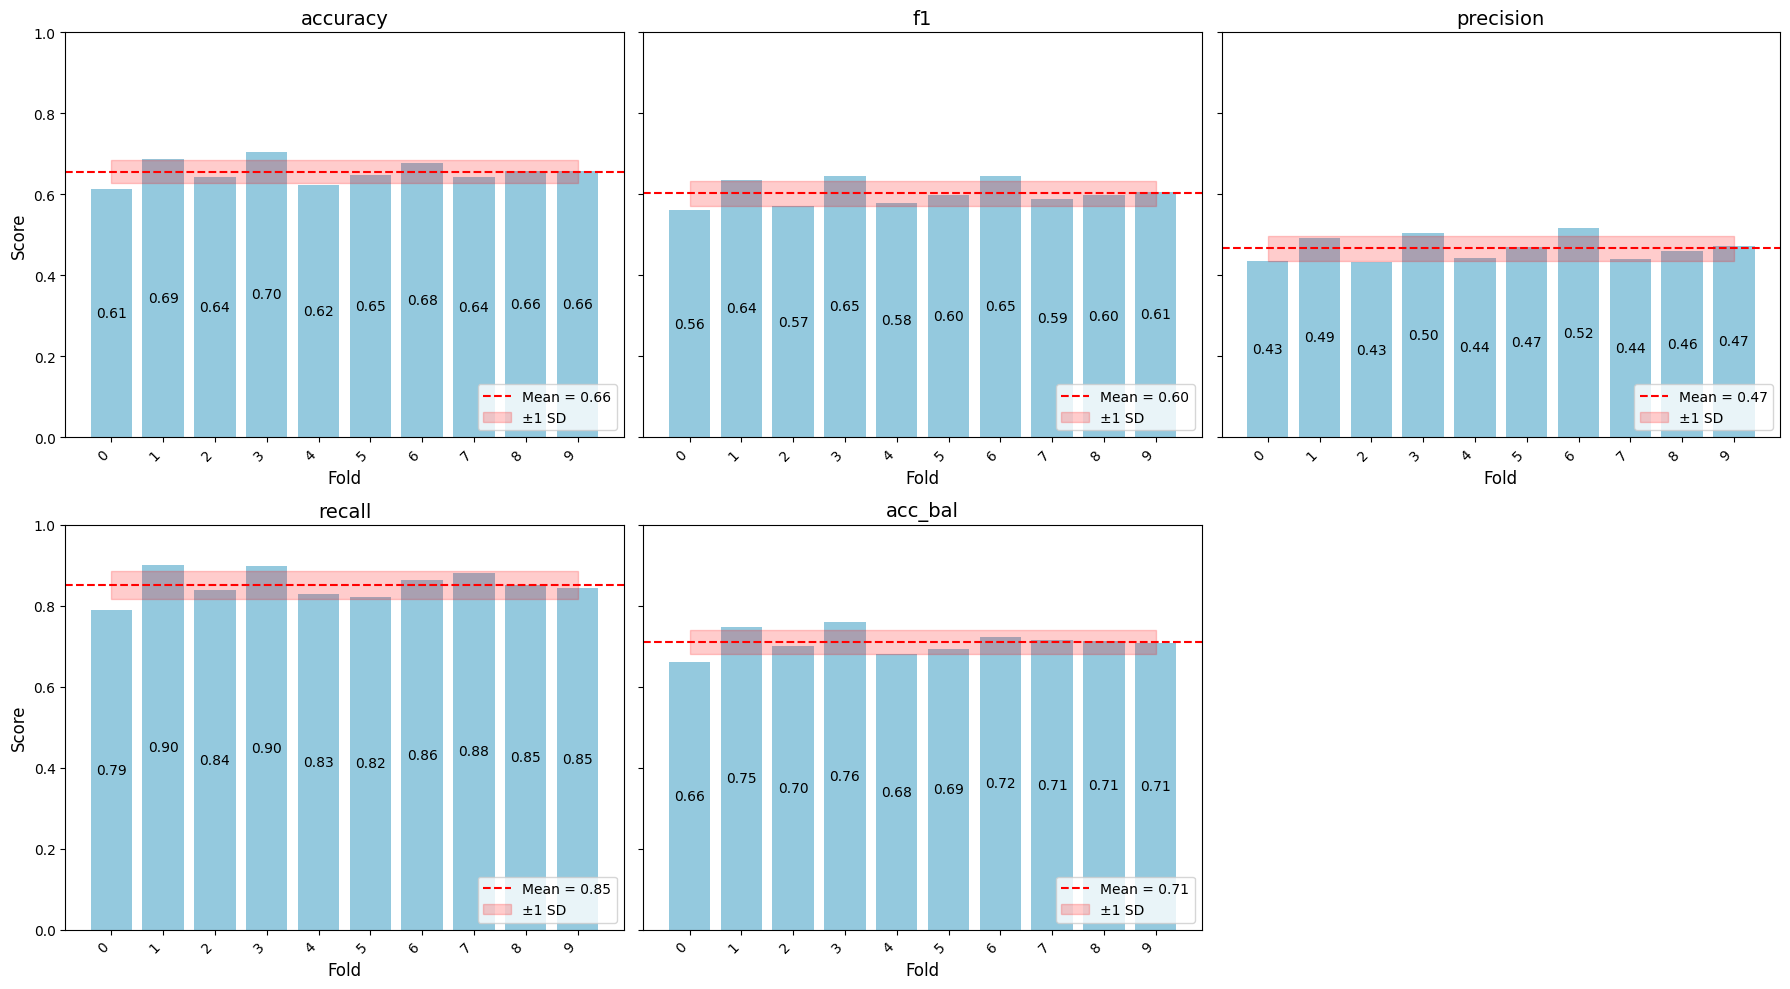

Fold 0: Accuracy = 0.5546, F1 = 0.5603
Fold 1: Accuracy = 0.5633, F1 = 0.5652
Fold 2: Accuracy = 0.5219, F1 = 0.5240
Fold 3: Accuracy = 0.5419, F1 = 0.5593
Fold 4: Accuracy = 0.5551, F1 = 0.5628
Fold 5: Accuracy = 0.5746, F1 = 0.5764
Fold 6: Accuracy = 0.5175, F1 = 0.5339
Fold 7: Accuracy = 0.5439, F1 = 0.5556
Fold 8: Accuracy = 0.5551, F1 = 0.5665
Fold 9: Accuracy = 0.6096, F1 = 0.6009

Mean across folds: Accuracy = 0.5537, F1 = 0.5605


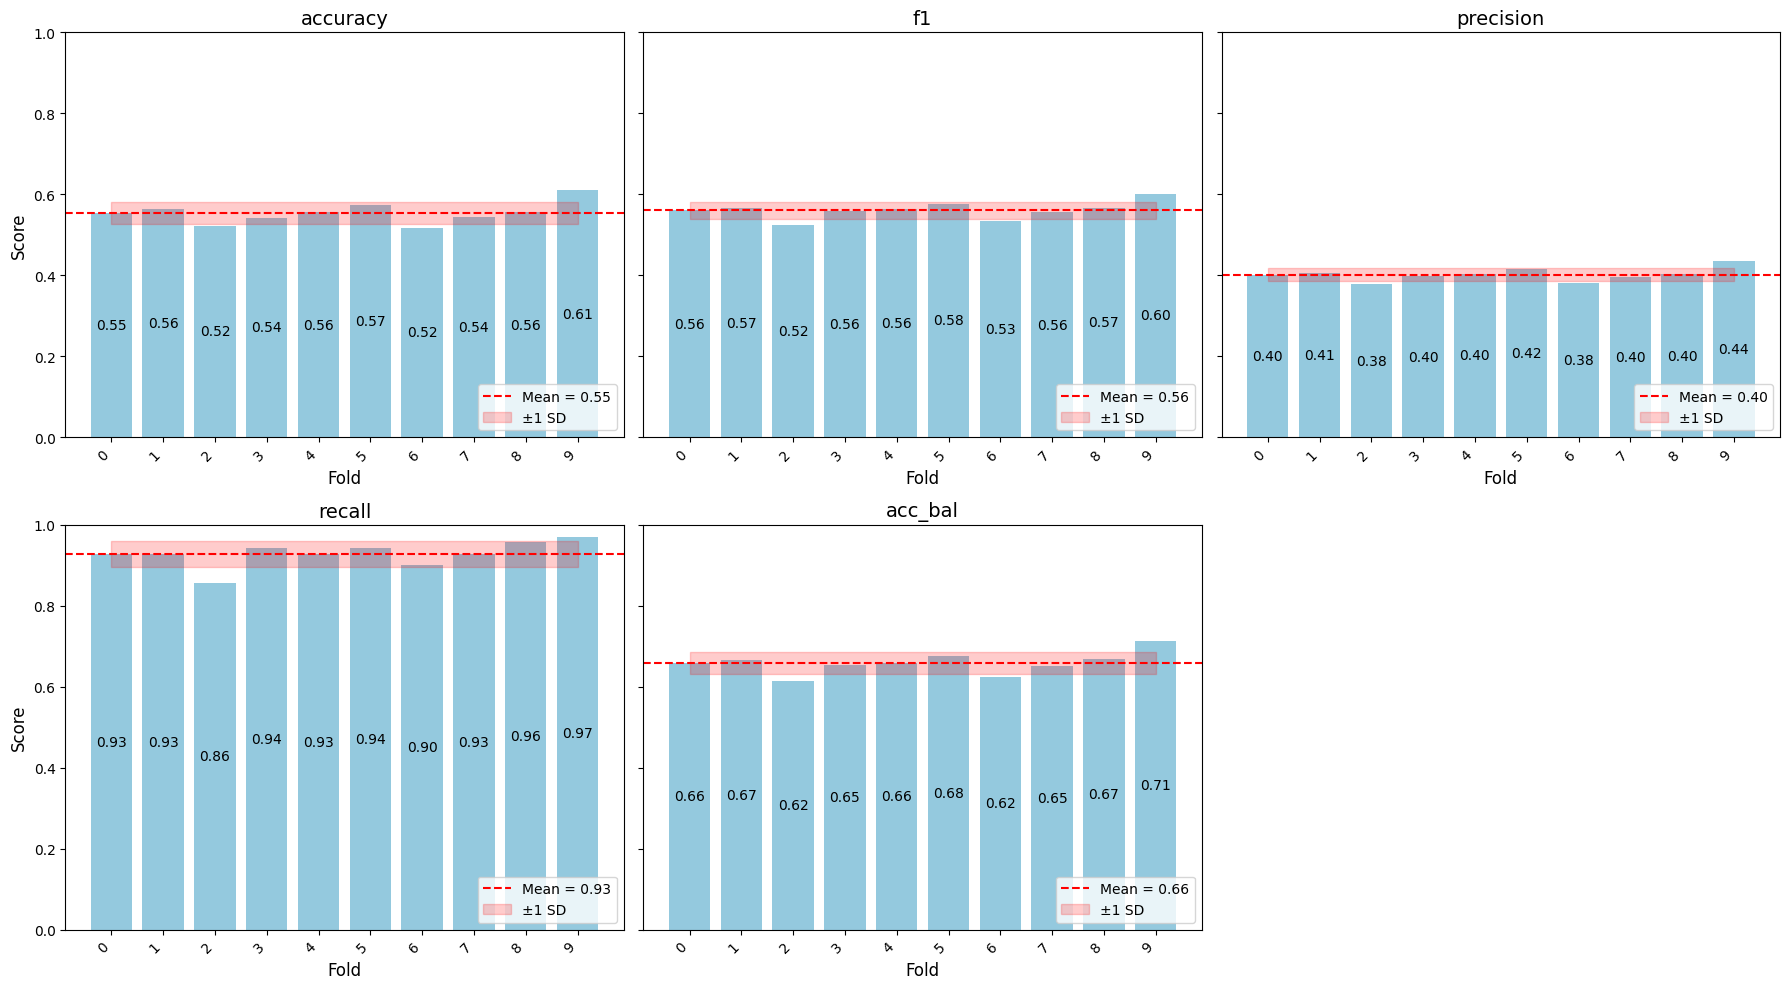

Fold 0: Accuracy = 0.6681, F1 = 0.6415
Fold 1: Accuracy = 0.5895, F1 = 0.5727
Fold 2: Accuracy = 0.5833, F1 = 0.5498
Fold 3: Accuracy = 0.6009, F1 = 0.5845
Fold 4: Accuracy = 0.5965, F1 = 0.5619
Fold 5: Accuracy = 0.6696, F1 = 0.6193
Fold 6: Accuracy = 0.5789, F1 = 0.5636
Fold 7: Accuracy = 0.6184, F1 = 0.5915
Fold 8: Accuracy = 0.6272, F1 = 0.6083
Fold 9: Accuracy = 0.6360, F1 = 0.6103

Mean across folds: Accuracy = 0.6168, F1 = 0.5903


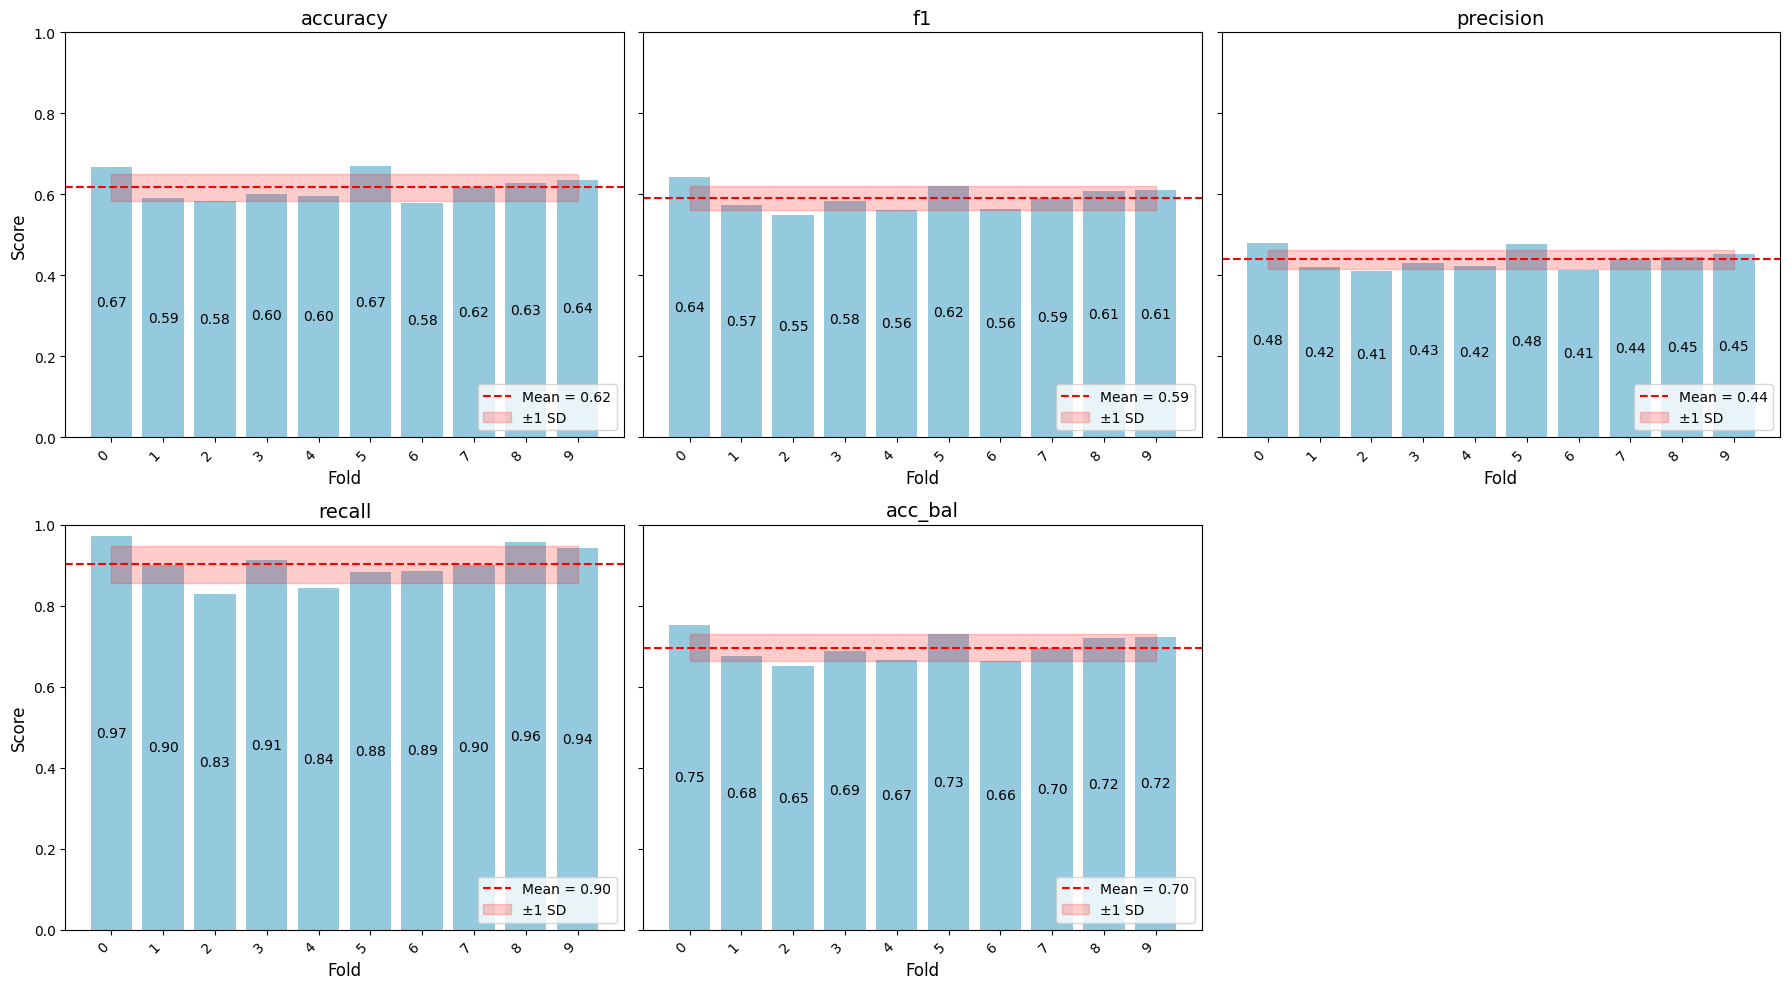

Fold 0: Accuracy = 0.6288, F1 = 0.6009
Fold 1: Accuracy = 0.6507, F1 = 0.5960
Fold 2: Accuracy = 0.7456, F1 = 0.6463
Fold 3: Accuracy = 0.6974, F1 = 0.6102
Fold 4: Accuracy = 0.6754, F1 = 0.6022
Fold 5: Accuracy = 0.6579, F1 = 0.5761
Fold 6: Accuracy = 0.5482, F1 = 0.5339
Fold 7: Accuracy = 0.5702, F1 = 0.5243
Fold 8: Accuracy = 0.6623, F1 = 0.6169
Fold 9: Accuracy = 0.5746, F1 = 0.5611

Mean across folds: Accuracy = 0.6411, F1 = 0.5868


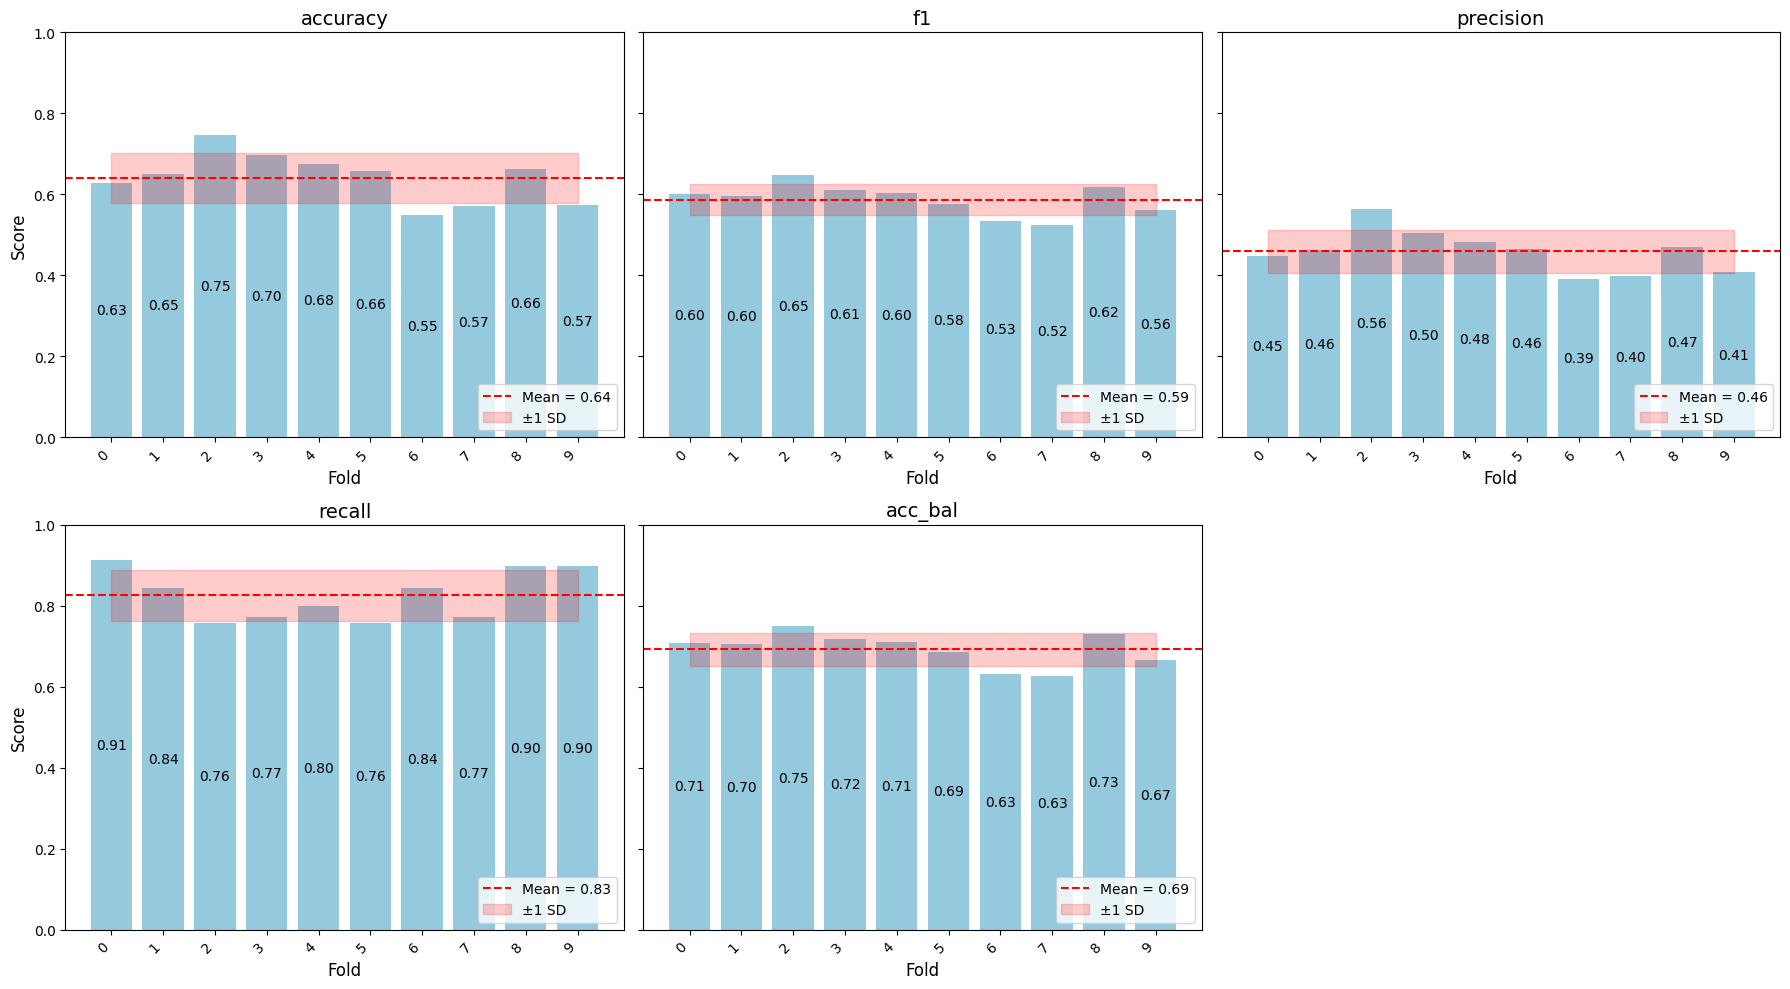

Fold 0: Accuracy = 0.5939, F1 = 0.5714
Fold 1: Accuracy = 0.6507, F1 = 0.6078
Fold 2: Accuracy = 0.7445, F1 = 0.6548
Fold 3: Accuracy = 0.6828, F1 = 0.6400
Fold 4: Accuracy = 0.6798, F1 = 0.6294
Fold 5: Accuracy = 0.6535, F1 = 0.6146
Fold 6: Accuracy = 0.5614, F1 = 0.5455
Fold 7: Accuracy = 0.5965, F1 = 0.5619
Fold 8: Accuracy = 0.5859, F1 = 0.5524
Fold 9: Accuracy = 0.5482, F1 = 0.5463

Mean across folds: Accuracy = 0.6297, F1 = 0.5924


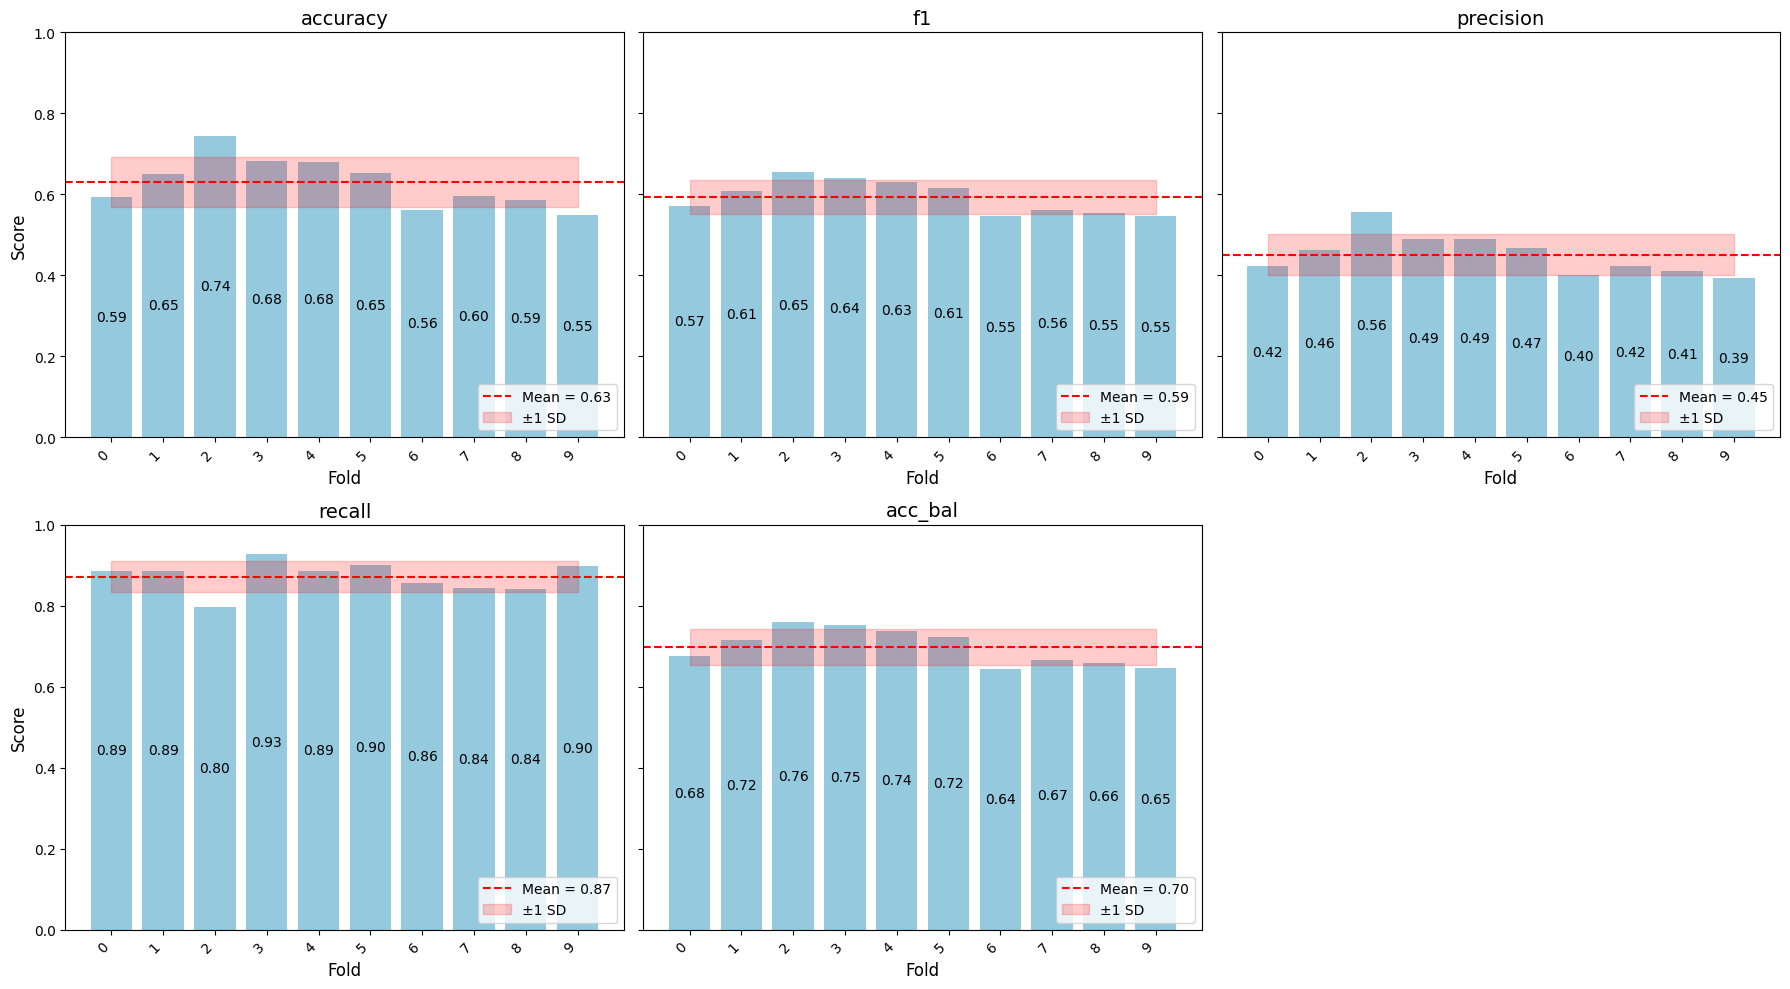

In [32]:
metrics_mini, acc_mini, f1_mini = evaluate_gemini_flash(gemini_flash_01_mini)
metrics_cot, acc_cot, f1_cot = evaluate_gemini_flash(gemini_flash_01_cot)
metrics_cot_sys, acc_cot_sys, f1_cot_sys = evaluate_gemini_flash(gemini_flash_01_cot_sys_instr)
metrics_cot_sys_random_shot_5, acc_cot_sys_random_shot_5, f1_cot_sys_random_shot_5 = evaluate_gemini_flash(gemini_flash_01_cot_sys_instr_shot_5)
metrics_cot_sys_random_knn_shot_5, acc_cot_sys_random_knn_shot_5, f1_cot_sys_random_shot_5 = evaluate_gemini_flash(gemini_flash_01_cot_sys_instr_knn_shot_5)

# SUMMARY PLOT

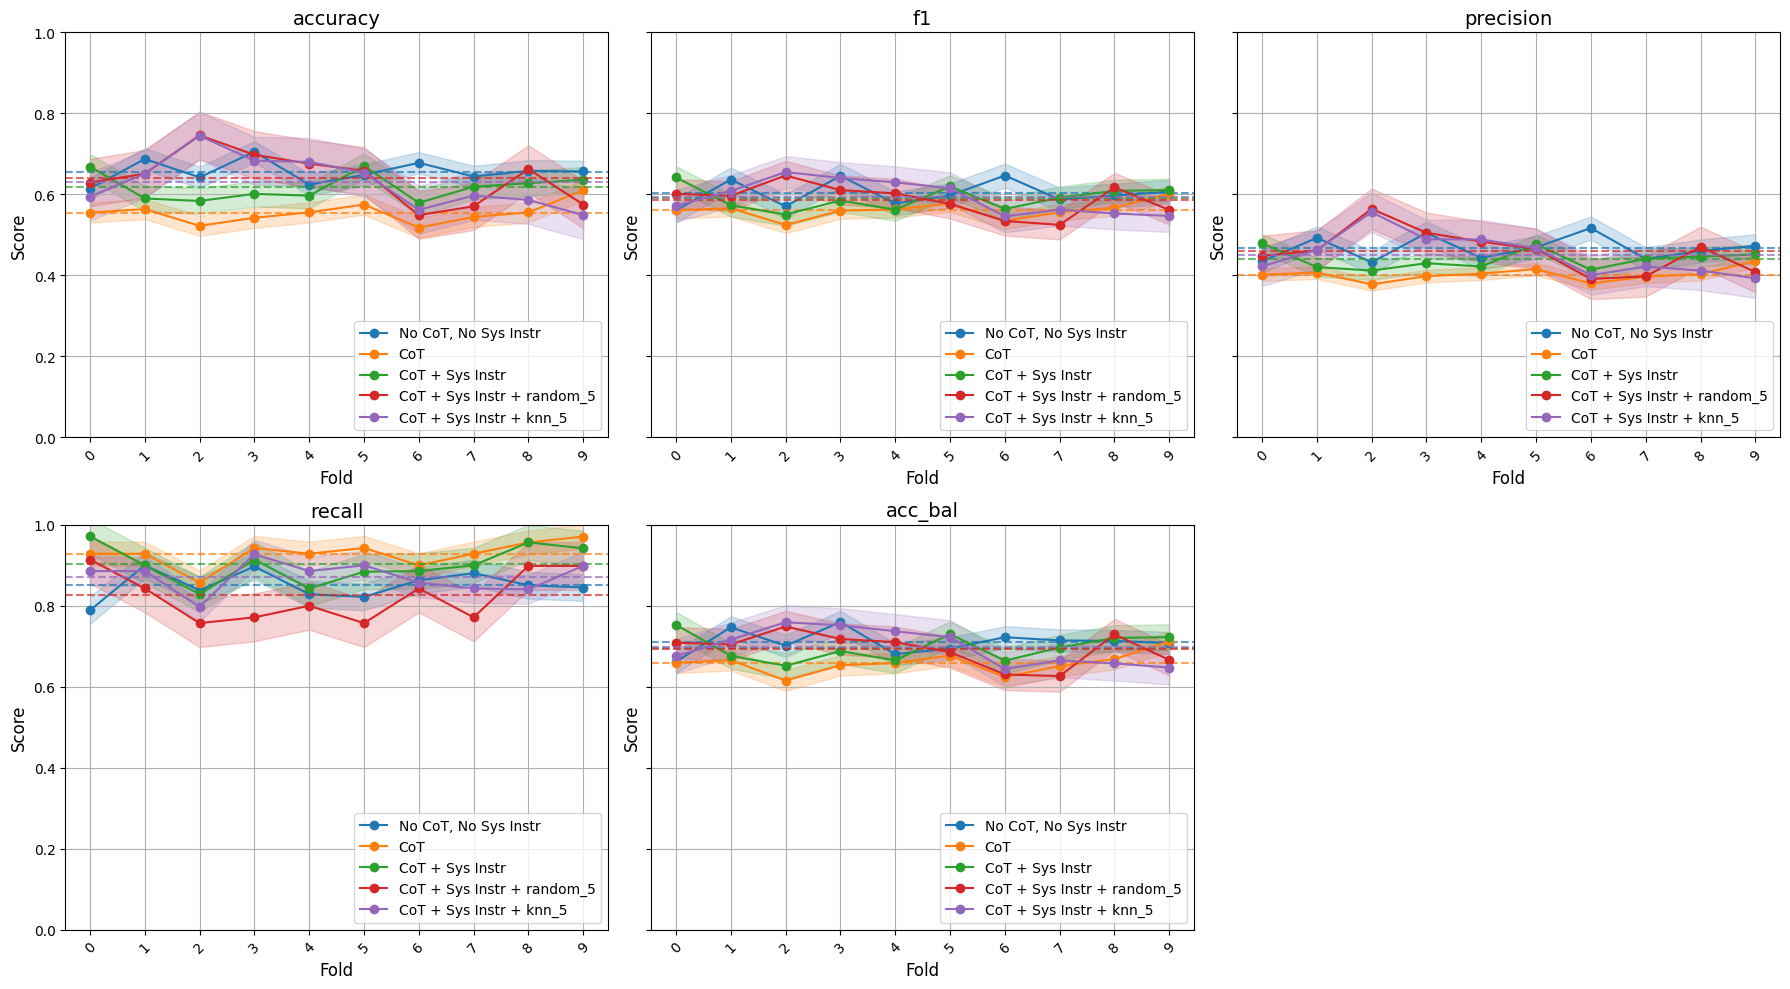

In [33]:
plot_gemini_experiments(
    metrics_list=[metrics_mini, metrics_cot, metrics_cot_sys, metrics_cot_sys_random_shot_5, metrics_cot_sys_random_knn_shot_5],
    labels=["No CoT, No Sys Instr", "CoT", "CoT + Sys Instr", "CoT + Sys Instr + random_5", "CoT + Sys Instr + knn_5" ]
)

# ECE

In [38]:
def compute_ece(y_true, y_prob, n_bins=10):
    
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    bin_edges = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    N = len(y_true)
    
    for i in range(n_bins):
        mask = (y_prob >= bin_edges[i]) & (y_prob < bin_edges[i+1])
        n_bin = np.sum(mask)
        if n_bin == 0:
            continue
        acc_bin = np.mean(y_true[mask])
        conf_bin = np.mean(y_prob[mask])
        ece += (n_bin / N) * np.abs(acc_bin - conf_bin)
    
    return ece

def ece_per_fold(df, folds_prefix="gemini_conf_val_fold_", n_bins=10):

    folds = [col for col in df.columns if col.startswith(folds_prefix)]
    
    results = {}
    
    for col in folds:
        fold_num = col.split('_')[-1]
        
        y_true = df['diabetic_retinopathy']
        y_prob = df[col].fillna(0).values
        
        ece_val = compute_ece(y_true, y_prob, n_bins=n_bins)
        results[f'fold_{fold_num}'] = ece_val
    
    all_probs = df[folds].fillna(0).values
    mean_probs = np.mean(all_probs, axis=1)
    results['all_data'] = compute_ece(df['diabetic_retinopathy'], mean_probs, n_bins=n_bins)
    
    return results

def plot_ece_multiple(datasets, labels=None):
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(datasets))]
    
    plt.figure(figsize=(10, 6))
    
    for df, label in zip(datasets, labels):
        ece_vals = ece_per_fold(df)
        folds = list(ece_vals.keys())
        values = list(ece_vals.values())
        
        plt.plot(folds, values, marker='o', label=label)
    
    plt.xticks(rotation=45)
    plt.ylabel("ECE")
    plt.ylim(0, 1)
    plt.title("Expected Calibration Error per Fold and Overall")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

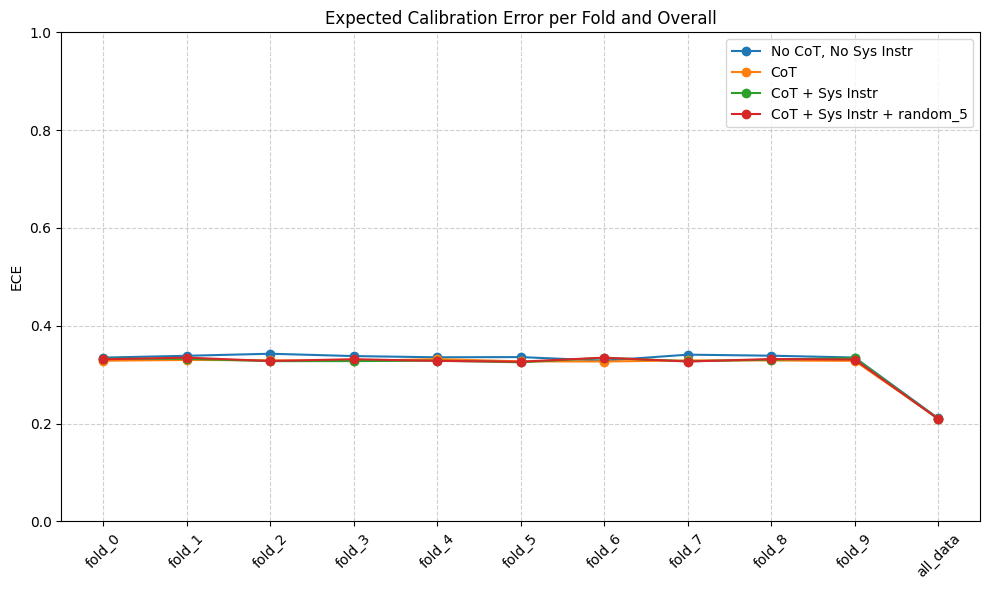

In [39]:
gemini_dfs = [gemini_flash_01_mini, gemini_flash_01_cot, gemini_flash_01_cot_sys_instr_shot_5, gemini_flash_01_cot_sys_instr_knn_shot_5 ]
plot_ece_multiple(gemini_dfs, labels=["No CoT, No Sys Instr", "CoT", "CoT + Sys Instr", "CoT + Sys Instr + random_5", "CoT + Sys Instr + knn_5" ])